# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [459]:
# import necessary libraries and packages
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time as time
from time import sleep
pd.options.display.max_columns=30


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

import datetime
import pickle


## I. Business Understanding

### Project Goals
In this project, I will create a model that will predict how much a customer will spend after 
<br>receiving a given offer from their demographic data.


## II. Data Understanding

In this step, I will explore the value counts and distributions of the variables in each of the tables

In [421]:
plt.style.use('fivethirtyeight')

In [422]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [423]:
portfolio.sort_values('offer_type')

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


In [424]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [425]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [426]:
# view shape of datasets
print('portfolio shape: ', portfolio.shape,
      '\nprofile shape: ', profile.shape, 
      '\ntranscript shape: ', transcript.shape)

portfolio shape:  (10, 6) 
profile shape:  (17000, 5) 
transcript shape:  (306534, 4)


### Portfolio DataFrame Understanding

In [427]:
print('portfolio_null_values:\n', portfolio.isnull().sum())

portfolio_null_values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


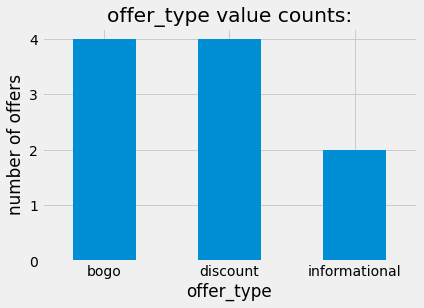

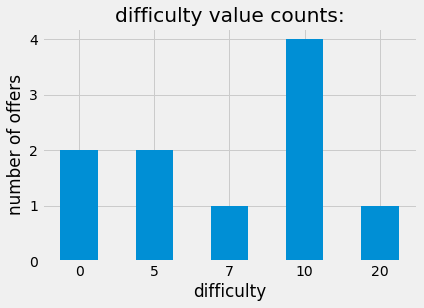

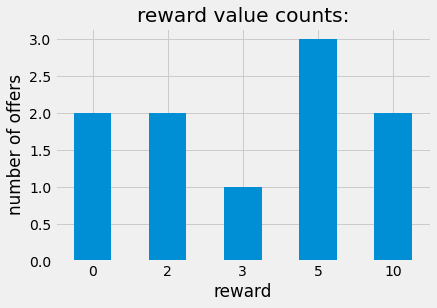

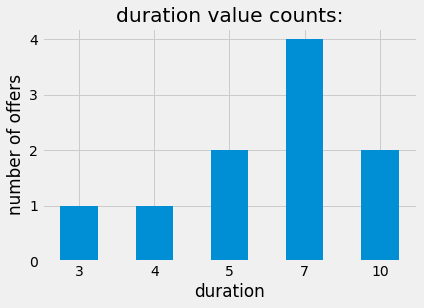

In [428]:
# How many of each offer type do we have? 

cols = ['offer_type', 'difficulty', 'reward', 'duration']

for col in cols:
    portfolio[col].value_counts().sort_index().plot.bar(title=col + " value counts:")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.ylabel('number of offers')
    plt.show()


### Profile DataFrame Understanding

In [429]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [430]:
print('profile_null_values:\n', profile.isnull().sum())

profile_null_values:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [431]:
age_118_idx = profile[profile['age'] == 118].index

gender_null_idx = profile[profile['gender'].isnull()].index

income_null_idx = profile[profile['income'].isnull()].index

set(age_118_idx) == set(gender_null_idx) == set(income_null_idx)

True

As I expected, the customers with null values in income nad gender also have an age of 118, which indicates that 118 was likely a placeholder to mean "unknown."

### Let's see how the demographic variables are distributed

<AxesSubplot:title={'center':'Gender'}>

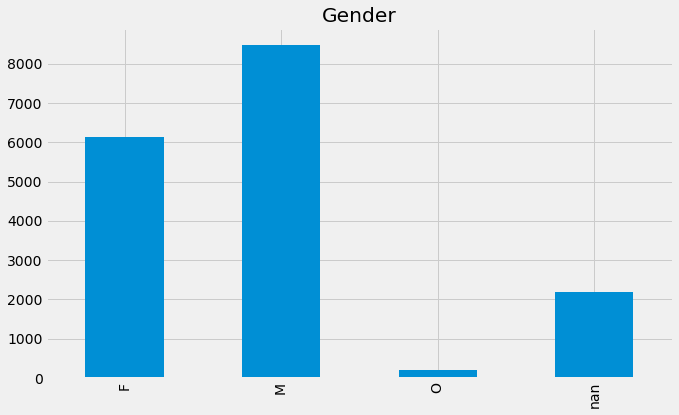

In [432]:
profile['gender'].value_counts(dropna=False).sort_index().plot.bar(figsize=(10,6), title="Gender")

In [433]:
def plot_hist(df, col, bin_size, x_range):
    """plots a histogram for a given column
    INPUTS
    df: df
    col (str): column in df
    bins (int): number of bins
    x_range (tup): range of x_values
    OUTPUTS
    histogram
    """
    rge = x_range[1] - x_range[0]
    bins = int(rge/bin_size)
    profile[col].plot.hist(figsize=(10,6), bins=bins, range=x_range, alpha=0.8)
    plt.xticks(ticks=np.arange(x_range[0], x_range[1]+1, bin_size))
    plt.xlabel(col)
    plt.title(col.title() + ' Histogram')
    plt.show()
    

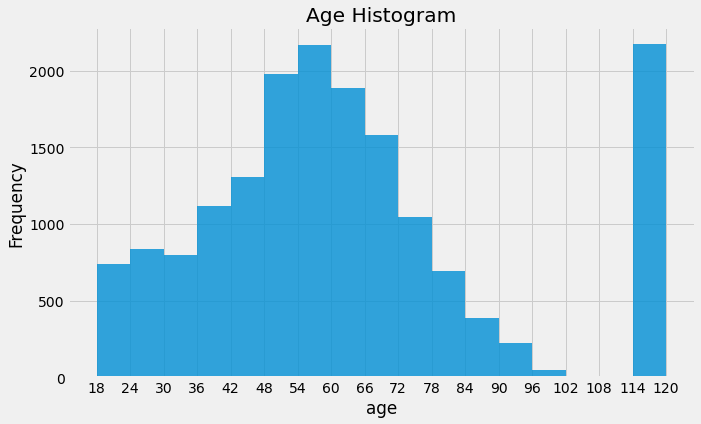

In [434]:
plot_hist(df=profile, col='age', bin_size=6, x_range=(18,120))

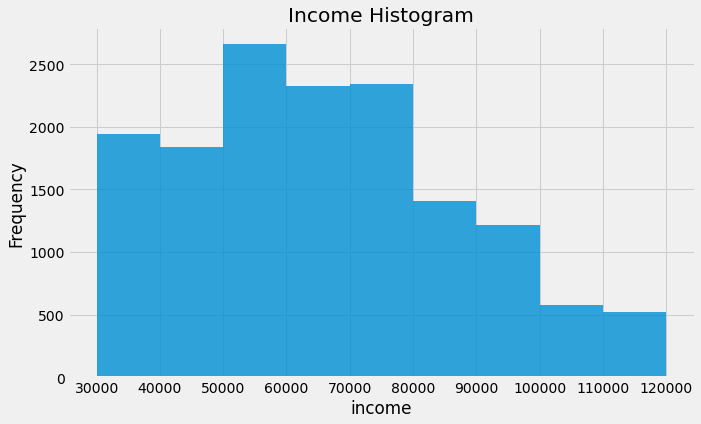

In [435]:
plot_hist(df=profile, col='income', bin_size=10000, x_range=(30000, 120000))

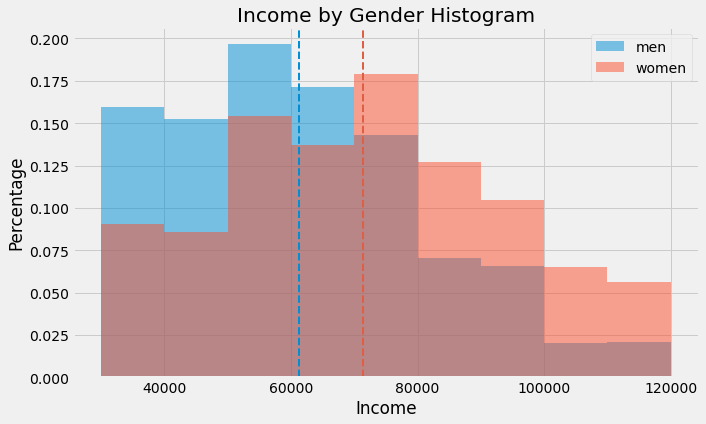

In [436]:
fig, ax = plt.subplots(figsize=(10,6))

bins = 9
men = profile.loc[profile['gender'] == 'M', 'income'] 
weights_m = np.ones_like(men) / float(len(men))

women = profile.loc[profile['gender'] == 'F', 'income']
weights_w = np.ones_like(women) / float(len(women))

# other = profile.loc[profile['gender'] == 'O', 'income']

ax.hist(men, bins=9, range=(30000,120000), weights=weights_m, alpha=0.5, label='men')
ax.hist(women, bins=9, range=(30000,120000), weights=weights_w, alpha=0.5, label='women')
# ax.hist(other, bins=9, range=(30000,120000), density=True, alpha=0.5, label='other')

ax.axvline(men.mean(), linewidth=2, ls='--')
ax.axvline(women.mean(), linewidth=2, ls='--', color='#DE5F43')
ax.set_title('Income by Gender Histogram')
ax.set_ylabel('Percentage')
ax.set_xlabel('Income')
plt.legend()

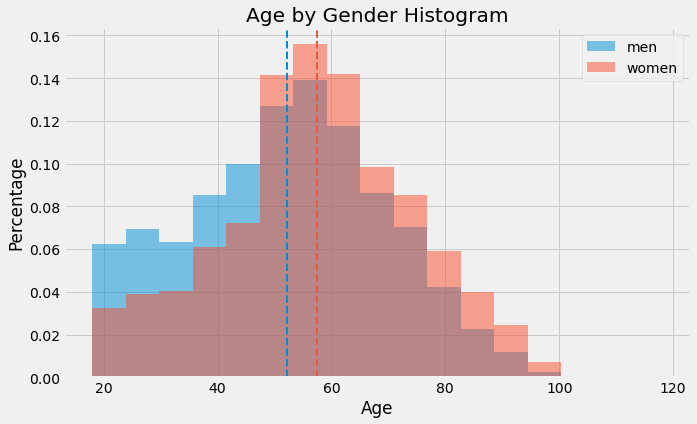

In [437]:
fig, ax = plt.subplots(figsize=(10,6))

bins=17

men = profile.loc[profile['gender'] == 'M', 'age']
weights_m = np.ones_like(men) / float(len(men))

women = profile.loc[profile['gender'] == 'F', 'age']
weights_w = np.ones_like(women) / float(len(women))

other = profile.loc[profile['gender'] == 'O', 'age']

ax.hist(men, bins=bins, range=(18,118), weights=weights_m, alpha=0.5, label='men')
ax.hist(women, bins=bins, range=(18,118), weights=weights_w, alpha=0.5, label='women')
# ax.hist(other, bins=bins, range=(18,118), alpha=0.5, label='other')
ax.axvline(men.mean(), linewidth=2, ls='--')
ax.axvline(women.mean(), linewidth=2, ls='--', color='#DE5F43')
ax.set_title('Age by Gender Histogram')
ax.set_ylabel('Percentage')
ax.set_xlabel('Age')
plt.legend()

381.0613743091652 44677.72038712164


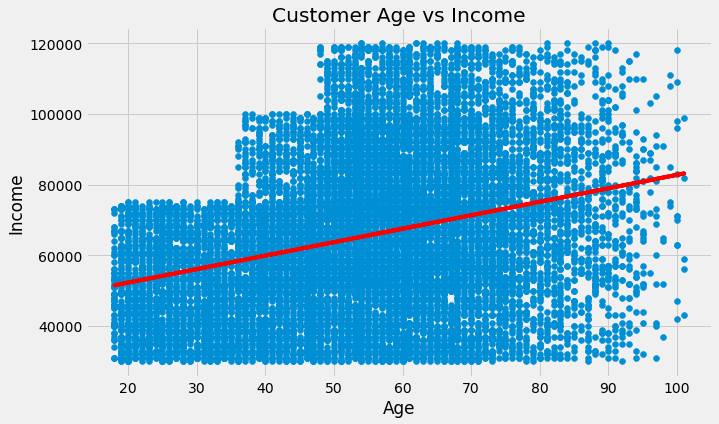

In [438]:
fig, ax = plt.subplots(figsize=(10,6))

data=profile.dropna()

X = data['age']
Y = data['income']
m, b = np.polyfit(X, Y, 1)
print(m, b)

ax.scatter(x=X, y=Y)
ax.plot(X, m*X+b, c='red')
ax.set_title('Customer Age vs Income')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_xticks(np.arange(20, 101, 10))

In [439]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [440]:
transcript.shape

(306534, 4)

In [441]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Text(0.5, 1.0, 'Event Types')

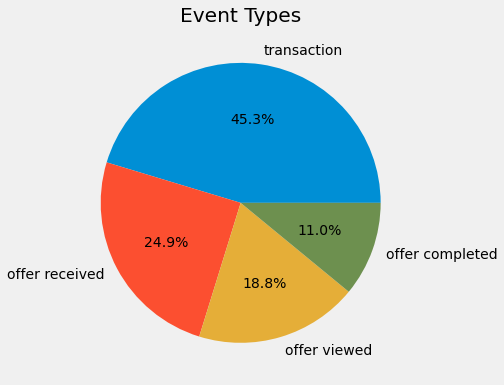

In [442]:
transcript['event'].value_counts(normalize=True).plot.pie(figsize=(10,6), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Event Types')

In [443]:
transcript['person'].nunique()

17000

In [444]:
profile['income'].mean()

65404.9915682968

### Data Understanding Summary

#### Portfolio

1. There are 10 different offers - 2 informational, 4 bogo, 4
2. The offer difficulties range from \\$0 \(for informational offers\) to \\$20, the most common being \\$10.
3. The offer rewards range from \\$0 \(for informational offers to\) \\$10, the most common being \\$5.
4. The offer durations range from 3 days to 10 days, the most common being 7 days.

#### Profile
1. There are 170,000 customers
2. There are 2,175 customers with null values in income and gender.
3. Ages range from 18 to 118. However, it appears 118 is used as a place holder, most likely indicating "unknown/not given" as customers with that age also have null values for income and gender.
4. The variable became_member_on is formated as an int, but should be converted to a datetime object for us to make use of it.
5. Income ranges from 30k to 120k, with the median being 64k.
6. The median income for female customers is \\$71k, \\$59k for male customers, and \\$62k for customers who marked Other.
7. The median age for female customers is 58, for male customers 53, and 55 for customers who marked their gender as Other.
8. Age and Income are positively correlated.
9. There are no customers between 18 and 36 who make over \\$75k. There are no users under 48 who make more than 100k.

#### Transcript
1. There are 306,534 rows, with each row being one of four events: 'offer received', 'offer viewed', 'offer completed', or 'transaction'.
2. 45.3% of the rows are transactions, 24.9% are offer received, 18.8% are offer viewed events, and 11% are offer completed.
3. The value column is a dictionary that gives the offer_id for an "offer received", "offer viewed" or "offer completed" event, and a transaction amount if the event is a transaction. <br>We will want to clean this columnn in the next section.
4. The times range from 0 to 714, and indicate the hour that the event occured in. The experiment ran for about 30 days. 


## III. Data Preparation

In this section I will clean each of the tables so that I can answer my questions and prepare the data for my model.
<br><br>**Portfolio DataFrame**

1. Add a column "readable_id" which contains a unique id that is easier to read than the hash id.
2. One-hot encode the channels column: 'email', 'mobile', 'social' or 'web'.
3. One-hot encode the offer_type: "bogo", "discount", or "informational".

<br>**Profile DataFrame**

1. Convert "became_member_on" column to a datetime object.
2. Replace the customers with age 118 with NaNs

<br>**Transcript**
1. Extract the offer id, amount, or reward from the dictioanry in the value column and store in its own column.
2. Drop the original value column

<br>**Create Offers DataFrame**
1. Transform transcript df to wide-form

<br>**Create Merged DataFrame**
1. Merge the profile and offers datasets.
2. Merge the resulting dataset with the profile dataset.
3. Drop repeated columns and reorder for readability. 

<br>**Create Master DataFrame**
1. Find find the total transaction amount spent under each offer

Finally, we will add two features and handle the null values so that our data is ready for the model. 

In [445]:
def clean_portfolio(portfolio):
    
    """Cleans the portfolio dataframe"""
    
    
    df = portfolio.copy()
    # Create an ID column that is more readable than the id hash
    df['readable_id'] = ['BOGO - $10 - 7days', 'BOGO - $10 - 5days', 'INFO - $0 - 4days', 'BOGO - $5 - 7days',
                           'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days', 'DISC - $10/\$2 - 10days', 'INFO - $0 - 3days',
                           'BOGO - $5 - 5days', 'DISC - \$10/\$2 - 7days']
    
    # Extract channels into their own columns one-hot encoded
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
  
    # Drop unneeded columns
    df.drop(columns=['channels'], inplace=True, errors='ignore')
   
    
    # Turn offer_type into a dummy variable
    new_df = pd.get_dummies(df, columns=['offer_type'], prefix='', prefix_sep='')
    new_df = pd.concat([new_df, df['offer_type']], axis=1)
    
    
    # Rename dummy columns
    new_df = new_df[['readable_id', 'id', 'offer_type', 'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    

    return new_df

clean_portfolio = clean_portfolio(portfolio)
clean_portfolio.to_csv('clean_portfolio.csv', index=False)


In [446]:
clean_portfolio.head(10)

,readable_id,id,offer_type,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational
0,BOGO - $10 - 7days,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,1,1,1,0,1,0,0
1,BOGO - $10 - 5days,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,1,1,1,1,1,0,0
2,INFO - $0 - 4days,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,1,1,0,1,0,0,1
3,BOGO - $5 - 7days,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,1,1,0,1,1,0,0
4,DISC - $20/\$5 - 10days,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,1,0,0,1,0,1,0
5,DISC - $7/\$3 - 7days,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,1,1,1,1,0,1,0
6,DISC - $10/\$2 - 10days,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,1,1,1,1,0,1,0
7,INFO - $0 - 3days,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,1,1,1,0,0,0,1
8,BOGO - $5 - 5days,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1,1,1,0,0
9,DISC - \$10/\$2 - 7days,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,1,1,0,1,0,1,0


In [447]:
def clean_profile(profile):
    """Cleans the profile dataframe
    1. Converts dates to datetime objects
    2. Extracts the year the member joined
    2. Sets age 118 to np.nan
    3. Creates columns for age_groups and income_groups.
    INPUT:
    profile dataframe
    OUTPUT:
    clean_profile dataframe
    """
    
    df = profile.copy()
    # Convert column to datetime object
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    

    # Change 118 to nan. This was likely used as a placeholder to indicate unknown.
    # Customers with this age also had null values for income and gender
    df.loc[df['age'] == 118, 'age'] = np.nan
    
    orig_num_rows = df.shape[0]
    print('Original Number of Rows: ', orig_num_rows)
            
    final_num_rows = df.shape[0]
    print('Final Number of Rows: ', final_num_rows)
    print('Null Values Dropped: ', orig_num_rows - final_num_rows)
    
    return df

clean_profile = clean_profile(profile)
clean_profile.to_csv('clean_profile.csv',index=False)

Original Number of Rows:  17000
Final Number of Rows:  17000
Null Values Dropped:  0


In [448]:
clean_profile

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [449]:
def clean_transcript(transcript):
    """Cleans the transcript dataframe
    1. Extracts the transaction amt, reward, or offer_id from the dictionary in the value column
    2. Drops the old value column
    INPUT: transcript df
    OUTPUT: clean_transcript df
    """
    df=transcript.copy()
    
    # Initialize new colums 
    df['offer_id'] = np.nan
    df['transaction_amt'] = np.nan
    df['reward'] = np.nan
    
    # Extract offer id from dictionary in value column
    df.loc[df['event'] == 'offer received', 'offer_id'] = df.loc[(df['event'] == 'offer received'), 'value'].str['offer id']

    df.loc[df['event'] == 'offer viewed', 'offer_id'] = df.loc[(df['event'] == 'offer viewed'), 'value'].str['offer id']

    df.loc[df['event'] == 'offer completed', 'offer_id']= df.loc[(df['event'] == 'offer completed'), 'value'].str['offer_id']
    
    # Extract reward from offer completed events
    df.loc[df['event'] == 'offer completed', 'reward'] = df.loc[df['event'] == 'offer completed', 'value'].str['reward']

    # Extract amount from transaction events
    df.loc[df['event'] == 'transaction', 'transaction_amt'] = df.loc[df['event'] == 'transaction', 'value'].str['amount']

    # Drop column no longer needed
    df = df.drop(columns=['value'])
    
    # Rename offer_ids to a more readable id that describes the offer
    offer_ids = clean_portfolio['id'].tolist()
    
    readable_offer_ids = ['BOGO - $10 - 7days', 'BOGO - $10 - 5days', 'INFO - $0 - 4days', 'BOGO - $5 - 7days',
                           'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days', 'DISC - $10/\$2 - 10days', 'INFO - $0 - 3days',
                           'BOGO - $5 - 5days', 'DISC - \$10/\$2 - 7days']
    
    offer_id_mapping = {}
    for i in range(len(offer_ids)):
        offer_id_mapping[offer_ids[i]] = readable_offer_ids[i]
    
    df['readable_id'] = df['offer_id'].replace(offer_id_mapping)
    
    return df

clean_transcript = clean_transcript(transcript)
clean_transcript.to_csv('clean_transcript.csv', index=False)

In [450]:
transactions = clean_transcript.loc[clean_transcript['event'] == 'transaction']

mean_transaction_amt = transactions['transaction_amt'].mean()
median_transaction_amt = transactions['transaction_amt'].median()

print('mean_transaction_amt:', mean_transaction_amt, '\nmedian_transaction_amt:', median_transaction_amt)

median_num_transactions = transactions.groupby('person')['transaction_amt'].size().median()

print("median number of transactions", median_num_transactions)

mean_transaction_amt: 12.77735615639814 
median_transaction_amt: 8.89
median number of transactions 7.0


In [451]:
received = clean_transcript.loc[clean_transcript['event'] == 'offer received']
mean_offers_received = received.groupby('person')['event'].size().mean()

viewed = clean_transcript.loc[clean_transcript['event'] == 'offer viewed']
mean_offers_viewed = viewed.groupby('person')['event'].size().mean()

completed = clean_transcript.loc[clean_transcript['event'] == 'offer completed']
mean_offers_completed = completed.groupby('person')['event'].size().mean()


print("mean number of offers received:", round(mean_offers_received, 1))
print("mean number of offers viewed:", round(mean_offers_viewed, 1))
print("mean number of offers completed:", round(mean_offers_completed, 1))



mean number of offers received: 4.5
mean number of offers viewed: 3.4
mean number of offers completed: 2.6


<AxesSubplot:ylabel='Frequency'>

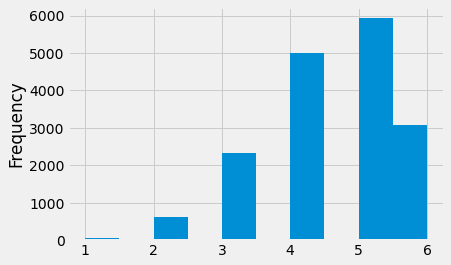

In [452]:
received.groupby('person')['event'].size().plot.hist()

In [453]:
def offers_to_wide_form(clean_transcript):
    """Converts transcript dataset to wide form, where each row has 
    offer_received_time, offer_viewed_time, and offer_completed_time
    """
    
    df = clean_transcript.copy()

    # For each person and offer_type, count how many of the same offers they have received, viewed, or completed
    df['num_offers_received'] = df.loc[df['event'] == 'offer received'].groupby(['person', 'readable_id']).cumcount()
    df['num_offers_viewed'] = df.loc[df['event'] == 'offer viewed'].groupby(['person', 'readable_id']).cumcount()
    df['num_offers_completed'] = df.loc[df['event'] == 'offer completed'].groupby(['person', 'readable_id']).cumcount()

    # Take the only non-null value from these three columns in each row
    df['duplicate_num'] = df[['num_offers_received', 'num_offers_viewed', 'num_offers_completed']].max(axis=1)

    # Attach the duplicate_num to each readable_id to distinguish which offer is being referred to if there are multiple offers open simultaneously
    df['readable_id_unique'] = df['readable_id'] + "_" + df['duplicate_num'].apply(lambda x: str(x)[0])

    # Store time in separate columns for received, viewed, or completed events
    df['offer_received_time'] = df.loc[df['event']=='offer received', 'time']
    df['offer_viewed_time'] = df.loc[df['event']=='offer viewed', 'time']
    df['offer_completed_time'] = df.loc[df['event']=='offer completed', 'time']

    # Subset relevant columns
    df = df[['person', 'readable_id', 'readable_id_unique', 'event', 'time', 'offer_received_time', 'offer_viewed_time', 'offer_completed_time']]

    # Create three separate dataframes of only received, viewed, and completed events
    received = df.loc[df['event'] == 'offer received']
    received = received[['person', 'readable_id', 'readable_id_unique', 'event', 'offer_received_time']]

    viewed = df.loc[df['event'] == 'offer viewed']
    viewed = viewed[['person', 'readable_id', 'readable_id_unique', 'event', 'offer_viewed_time']]

    completed = df.loc[df['event'] == 'offer completed']
    completed = completed[['person', 'readable_id', 'readable_id_unique', 'event', 'offer_completed_time']]

    # Merge the received and viewed events
    received_viewed = pd.merge(received, viewed, how='left', on=['person', 'readable_id_unique'])

    # Merge the above df with the completed df to get data in wide form.
    offers_full = pd.merge(received_viewed, completed, how='left', on=['person', 'readable_id_unique'])

    # Now each row has a offer_received_time, offer_viewed_time and offer_completed_time (null if not viewed/completed)
    offers_full = offers_full[['person', 'readable_id_unique', 'offer_received_time', 'offer_viewed_time', 'offer_completed_time']]
    
    offers_full['readable_id'] = offers_full['readable_id_unique'].str[:-2]
    
    return offers_full

In [454]:
offers_full = offers_to_wide_form(clean_transcript)

In [455]:
offers_full

,person,readable_id_unique,offer_received_time,offer_viewed_time,offer_completed_time,readable_id
0,78afa995795e4d85b5d9ceeca43f5fef,BOGO - $5 - 7days_0,0.0,6.0,132.0,BOGO - $5 - 7days
1,a03223e636434f42ac4c3df47e8bac43,DISC - $20/\$5 - 10days_0,0.0,6.0,NaN,DISC - $20/\$5 - 10days
2,e2127556f4f64592b11af22de27a7932,DISC - \$10/\$2 - 7days_0,0.0,18.0,NaN,DISC - \$10/\$2 - 7days
3,8ec6ce2a7e7949b1bf142def7d0e0586,DISC - $10/\$2 - 10days_0,0.0,12.0,NaN,DISC - $10/\$2 - 10days
4,68617ca6246f4fbc85e91a2a49552598,BOGO - $10 - 5days_0,0.0,84.0,NaN,BOGO - $10 - 5days
...,...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,BOGO - $10 - 7days_0,576.0,672.0,636.0,BOGO - $10 - 7days
76273,cb23b66c56f64b109d673d5e56574529,DISC - \$10/\$2 - 7days_1,576.0,NaN,NaN,DISC - \$10/\$2 - 7days
76274,6d5f3a774f3d4714ab0c092238f3a1d7,DISC - $7/\$3 - 7days_0,576.0,588.0,NaN,DISC - $7/\$3 - 7days
76275,9dc1421481194dcd9400aec7c9ae6366,BOGO - $10 - 7days_0,576.0,624.0,594.0,BOGO - $10 - 7days


In [456]:
def create_merged_df(portfolio_df=clean_portfolio, profile_df=clean_profile, offers_full=offers_full):
    """Merges the three datasets to one master df
    INPUTS
    portfolio_df: dataframe of offers including and 'offer_id' column with offer id's
    profile_df: dataframe of customer demographic data including an 'id' column with customer id's
    offers_full: dataframe of every offer and the amount spend after viewing an offer
    
    OUTPUTS
    master_df: a dataframe of every offer during experiment with demographic data
    """
    
    # merge offers_full and profile_df on customer id
    df = pd.merge(offers_full, profile_df, how='left', left_on='person', right_on='id')
    
    # drop 'id' column because this is the same as the 'person' column
    df.drop(columns=['id'], inplace=True)
    
    # merge above df with portfolio_df to include information about offers
    merged_df = pd.merge(df, portfolio_df, how='left', on='readable_id')
    
    
    merged_df = merged_df[['person', 'gender', 'age', 'became_member_on', 'income', 'readable_id', 'readable_id_unique', 'offer_received_time', 'offer_viewed_time',
                          'offer_completed_time', 'offer_type', 'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    
    merged_df['offer_end'] = merged_df['offer_received_time'] + merged_df['duration']*24
    
    return merged_df

merged_df = create_merged_df()
merged_df.head()

,person,gender,age,became_member_on,income,readable_id,readable_id_unique,offer_received_time,offer_viewed_time,offer_completed_time,offer_type,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational,offer_end
0,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,BOGO - $5 - 7days,BOGO - $5 - 7days_0,0.0,6.0,132.0,bogo,5,5,7,1,1,0,1,1,0,0,168.0
1,a03223e636434f42ac4c3df47e8bac43,None,NaN,2017-08-04,NaN,DISC - $20/\$5 - 10days,DISC - $20/\$5 - 10days_0,0.0,6.0,NaN,discount,20,5,10,1,0,0,1,0,1,0,240.0
2,e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,70000.0,DISC - \$10/\$2 - 7days,DISC - \$10/\$2 - 7days_0,0.0,18.0,NaN,discount,10,2,7,1,1,0,1,0,1,0,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,None,NaN,2017-09-25,NaN,DISC - $10/\$2 - 10days,DISC - $10/\$2 - 10days_0,0.0,12.0,NaN,discount,10,2,10,1,1,1,1,0,1,0,240.0
4,68617ca6246f4fbc85e91a2a49552598,None,NaN,2017-10-02,NaN,BOGO - $10 - 5days,BOGO - $10 - 5days_0,0.0,84.0,NaN,bogo,10,10,5,1,1,1,1,1,0,0,120.0


In [457]:
def total_amt_spent_under_offer(merged_df = merged_df, clean_transcript=clean_transcript):
    """Calculates the amount spent for each received offer, between the time that 
    the offer was viewed and the time the offer expires"""
    df = merged_df.copy()
    df['amt_spent_under_offer'] = 0
    transactions = clean_transcript.loc[clean_transcript['event'] == 'transaction']

    for person in tqdm(transactions['person'].unique(), desc='progress'):
        customer_transactions = transactions[transactions['person'] == person]
        customer_offers = df[df['person'] == person]

        for offer in customer_offers.itertuples():
            idx = offer[0]
            received_time = offer.offer_received_time
            viewed_time = offer.offer_viewed_time
            offer_end = offer.offer_end
            
            if np.isnan(viewed_time):
                amt_spent = 0

            else:
                amt_spent = customer_transactions.loc[customer_transactions['time'].between(viewed_time, offer_end), 'transaction_amt'].sum()

            df.loc[idx, 'amt_spent_under_offer'] = amt_spent
    
    return df


master_df = total_amt_spent_under_offer(merged_df)   

progress: 100%|██████████████████████████████████████████████████████████████████| 16578/16578 [06:51<00:00, 40.27it/s]


In [458]:
master_df.to_csv('master_df.csv', index=False)

If you don't want to run the function, you can just use this:

## Feature Engineering

We will add two features:
1. num_offers_viewed: The nubmer of offers the user has viewed previous to the current one
2. days_since_member: The number of days the user has been a member since 2019-01-01

In [460]:
master_df = pd.read_csv('master_df.csv')


In [461]:
# num_offers_viewed 

master_df['num_offers_viewed'] = 0

master_df.loc[master_df['offer_viewed_time'].notna(), 'num_offers_viewed'] = master_df.loc[master_df['offer_viewed_time'].notna()].groupby(['person']).cumcount()

In [462]:
# The most recent customer in the experiment became a member on 2018-07-26
# We will assume the experiment was conducted on 2019-01-01, and thus use that date to find the number of days that have passed since the customer became a member.

master_df['days_since_member'] = datetime.datetime(2019,1,1) - pd.to_datetime(master_df['became_member_on'])
master_df['days_since_member'] = master_df['days_since_member'].apply(lambda x: x.days)


# Modeling
In this section we will test out four models and select the one that does the best.

# Handling the Null Values

We have two options:
1. Drop any null rows
2. Impute the rows with the mean or most frequent value

We can try both and see which performs best with the baseline models

## Dropping Null Values


In [463]:
from sklearn.metrics import mean_squared_error
# Drop any null values

dropped_nulls = master_df.dropna()

# Select only viewed offers and drop null values
viewed_offers = dropped_nulls.loc[dropped_nulls['offer_viewed_time'].notnull()]

# Select features
features = viewed_offers[['gender', 'age', 'income', 'days_since_member', 'num_offers_viewed', 'readable_id']]

X_nulls_dropped = pd.get_dummies(features, columns = ['readable_id', 'gender'], prefix='', prefix_sep='')

y_nulls_dropped = viewed_offers['amt_spent_under_offer']

X_nulls_dropped


X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_nulls_dropped, y_nulls_dropped)

en = ElasticNet(normalize=True)
svr = SVR()
rf = RandomForestRegressor()
xgbr = xgb.XGBRegressor()

models = [en, svr, rf, xgbr]

train_rmses = []
test_rmses = []

for model in models:
    model.fit(X_train_nd, y_train_nd)
    y_preds_train = model.predict(X_train_nd)
    train_rmse = mean_squared_error(y_train_nd, y_preds_train, squared=False)
    train_rmses.append(train_rmse)
    
    y_preds_test = model.predict(X_test_nd)
    test_rmse = mean_squared_error(y_test_nd, y_preds_test, squared=False)
    test_rmses.append(test_rmse)
    
pd.DataFrame({'Model':models,
              'Training Set RMSE':train_rmses,
              'Test Set RMSE':test_rmses})
    
    
    

KeyboardInterrupt: 

## Imputing Null Values

In [ ]:
# Impute null values:
mean_days_since_member = (datetime.datetime(2019,1,1) - pd.to_datetime(clean_profile['became_member_on'])).dt.days.mean()


master_df.loc[master_df['age'].isnull(), 'age'] = clean_profile['age'].mean()
master_df.loc[master_df['gender'].isnull(), 'gender'] = 'M'
master_df.loc[master_df['income'].isnull(), 'income'] = clean_profile['income'].mean()
master_df.loc[master_df['days_since_member'].isnull(), 'days_since_member'] = mean_days_since_member

viewed_offers = master_df.loc[master_df['offer_viewed_time'].notnull()]

features = viewed_offers[['gender', 'age', 'income', 'days_since_member', 'num_offers_viewed', 'readable_id']]

X_imp = pd.get_dummies(features, columns=['readable_id', 'gender'], prefix='', prefix_sep='')
y_imp = viewed_offers['amt_spent_under_offer']

# Train Test Split with imputed dataset
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2)

en = ElasticNet(normalize=True)
svr = SVR()
rf = RandomForestRegressor()
xgbr = xgb.XGBRegressor()

models = [en, svr, rf, xgbr]

train_rmses = []
test_rmses = []

for model in models:
    model.fit(X_train_imp, y_train_imp)
    y_preds_train = model.predict(X_train_imp)
    train_rmse = mean_squared_error(y_train_imp, y_preds_train, squared=False)
    train_rmses.append(train_rmse)
    
    y_preds_test = model.predict(X_test_imp)
    test_rmse = mean_squared_error(y_test_imp, y_preds_test, squared=False)
    test_rmses.append(test_rmse)
    
pd.DataFrame({'Model':models,
              'Training Set RMSE':train_rmses,
              'Test Set RMSE':test_rmses})
    
    

In [480]:
# For reference

mean_amt_spent = viewed_offers['amt_spent_under_offer'].mean()

print(f"Customers spend on average ${mean_amt_spent:.2f} from when they view an offer to when the offer ends")

Customers spend on average $49.34 from when they view an offer to when the offer ends


## Hyper Parameter Tuning

In [468]:
# Support Vector Regressor

pipeline = Pipeline([
    ('normalize', Normalizer()),
    ('est', SVR())
])

params = {'est__kernel':['rbf', 'poly'], 
          'est__degree':[4, 5],
          'est__C':[10, 30, 100],
          'est__gamma':[1, 3, 10]}

svr_gs = GridSearchCV(estimator=pipeline, param_grid = params, scoring='neg_root_mean_squared_error', cv=3, verbose=2)

svr_gs.fit(X_train_imp, y_train_imp)

print("Best_estimator:", svr_gs.best_estimator_)

y_preds = svr_gs.predict(X_test_imp)

svr_rmse = mean_squared_error(y_test_imp, y_preds, squared=False)
svr_mae = mean_absolute_error(y_test_imp, y_preds)

print("SVR_MSE", svr_rmse)
print("SVR_MAE", svr_mae)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] est__C=100, est__degree=5, est__gamma=3, est__kernel=poly .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  est__C=100, est__degree=5, est__gamma=3, est__kernel=poly, total=  47.4s
[CV] est__C=100, est__degree=5, est__gamma=3, est__kernel=poly .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s remaining:    0.0s


[CV]  est__C=100, est__degree=5, est__gamma=3, est__kernel=poly, total=  45.1s
[CV] est__C=100, est__degree=5, est__gamma=3, est__kernel=poly .......
[CV]  est__C=100, est__degree=5, est__gamma=3, est__kernel=poly, total=  45.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


Best_estimator: Pipeline(steps=[('normalize', Normalizer()),
                ('est', SVR(C=100, degree=5, gamma=3, kernel='poly'))])
SVR_MSE 56.01043175528131
SVR_MAE 23.544222924120472


best model: SVR(C=100, degree=5, gamma=3, kernel='poly')

In [469]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('normalize', Normalizer()),
    ('est', RandomForestRegressor())
])

params = {'est__max_depth':[None, 4, 6], 
         'est__min_samples_split': np.linspace(0.1, 1, 5),
         'est__min_samples_leaf':np.linspace(0.1, 1, 5)}

rf_gs = GridSearchCV(estimator=pipeline, param_grid = params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

rf_gs.fit(X_train_imp, y_train_imp)

print("Best_estimator:", rf_gs.best_estimator_)

best_rf = rf_gs.best_estimator_

y_preds = best_rf.predict(X_test_imp)

rf_rmse = mean_squared_error(y_test_imp, y_preds, squared=False)
rf_mae = mean_absolute_error(y_test_imp, y_preds)

print("Random Forest RMSE", rf_rmse)
print("Random Forest MAE", rf_mae)


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 218 out of 225 | elapsed:   23.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   23.8s finished


Best_estimator: Pipeline(steps=[('normalize', Normalizer()),
                ('est',
                 RandomForestRegressor(max_depth=4, min_samples_leaf=0.1,
                                       min_samples_split=0.1))])
Random Forest RMSE 52.31938282209946
Random Forest MAE 23.927313318637516


best rf: RandomForestRegressor(max_depth=6, min_samples_leaf=0.1,
                                       min_samples_split=0.1))])

In [471]:
pipeline = Pipeline([
    ('normalize', Normalizer()),
    ('est', ElasticNet())
])

params = {'est__alpha':np.logspace(-2, 2, 10),
         'est__l1_ratio':np.linspace(0.1, 0.9, 9)}
en_gs = GridSearchCV(estimator = pipeline, param_grid = params,
                    scoring = 'neg_root_mean_squared_error')

en_gs.fit(X_train_imp, y_train_imp)


y_preds = en_gs.predict(X_test_imp)

en_rmse = mean_squared_error(y_test_imp, y_preds, squared=False)
en_mae = mean_absolute_error(y_test_imp, y_preds)


print("Elastic Net Regression RMSE", en_rmse)
print("Elastic Net MAE", en_mae)

print(en_gs.best_params_)

Elastic Net Regression RMSE 54.126519593933544
Elastic Net MAE 27.26734262769461
{'est__alpha': 0.01, 'est__l1_ratio': 0.1}


best_en: 'est__alpha': 0.01, 'est__l1_ratio': 0.1

In [472]:
params = {'max_depth': [2, 3, 4, 5, 6],
         'subsample':[0.85, 0.9, 0.95],
         'colsample_bytree':[0.9, 0.95, 1],
         'gamma': [0]}

xgbr_cv = GridSearchCV(xgb.XGBRegressor(),
                       param_grid = params,
                       scoring='neg_root_mean_squared_error',
                       verbose = 1)

xgbr_cv.fit(X_train_imp, y_train_imp)

best_xgbr = xgbr_cv.best_estimator_

y_preds = best_xgbr.predict(X_test_imp)

xgb_rmse = mean_squared_error(y_test_imp, y_preds, squared=False)
xgb_mae = mean_absolute_error(y_test_imp, y_preds)

print("XGB RMSE", xgb_rmse)
print("XGB MAE", xgb_mae)
print(best_xgbr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   34.1s finished


XGB RMSE 49.84361911646839
XGB MAE 21.21206198082625
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [473]:
models = ['Elastic Net', 'Support Vector Regressor', 'Random Forest Regressor', 'XGBoost Regressor']
RMSEs = [en_rmse, svr_rmse, rf_rmse, xgb_rmse]
MAEs = [en_mae, svr_mae, rf_mae, xgb_mae]
results = pd.DataFrame({'Models':models, 'RMSE':RMSEs, 'MAE':MAEs})

results

,Models,RMSE,MAE
0,Elastic Net,54.126520,27.267343
1,Support Vector Regressor,56.010432,23.544223
2,Random Forest Regressor,52.319383,23.927313
3,XGBoost Regressor,49.843619,21.212062


In [380]:
final_xgbr = xgb.XGBRegressor(max_depth = 2,
                    subsample=0.95,
                    colsample_bytree=1,
                    gamma=0)

final_xgbr.fit(X_imp, y_imp)




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [481]:

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(final_xgbr, file)

## Model Summary

After training all four models, it appears that XGBoost Regressor has the lowest RMSE.
<br>Thus, we used that model with hyperparameters to train on the entire dataset. 
<br>Finally, we saved our model so it is now ready to use on new data.

## Using the Model

In [ ]:
# First, load the model
with open('xgb_model.pkl', 'rb') as file:
    final_xgbr = pickle.load(file)
    

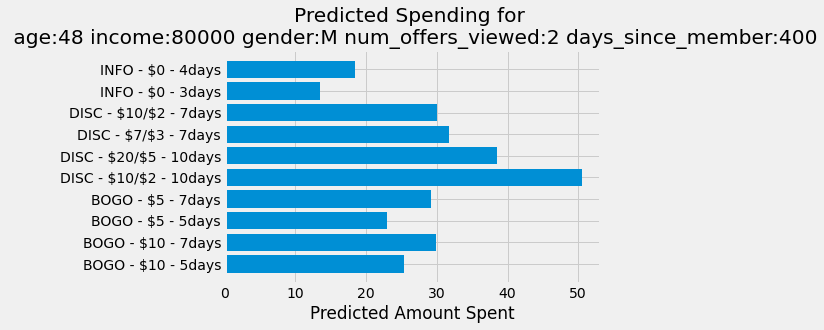

,Coupon,Predicted Amount Spent
0,BOGO - $10 - 5days,25.33
1,BOGO - $10 - 7days,29.82
2,BOGO - $5 - 5days,22.91
3,BOGO - $5 - 7days,29.15
4,DISC - $10/\$2 - 10days,50.59
5,DISC - $20/\$5 - 10days,38.52
6,DISC - $7/\$3 - 7days,31.66
7,DISC - \$10/\$2 - 7days,29.99
8,INFO - $0 - 3days,13.53
9,INFO - $0 - 4days,18.49


In [398]:
def which_coupon(age, income, gender, num_offers_viewed, days_since_member, model):
    """
    This function takes in customer demographic data gives a predicted spending
    amount for each offer in a dataframe and graph.
    INPUTS:
    age
    income
    gender
    num_offers_viewed
    days_since_member
    model: model used to make predictions
    OUTPUTS:
    results df
    """
    coupons = ['BOGO - $10 - 5days', 'BOGO - $10 - 7days', 'BOGO - $5 - 5days',
       'BOGO - $5 - 7days', 'DISC - $10/\$2 - 10days',
       'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days',
       'DISC - \$10/\$2 - 7days', 'INFO - $0 - 3days', 'INFO - $0 - 4days']
    
    rows = []
    for coupon in coupons:
        features = [age, income, gender, num_offers_viewed, days_since_member]
        features.append(coupon)
#         print(features.append(coupon))
        rows.append(features)
    
    df = pd.DataFrame(rows, columns=['age', 'income', 'gender', 'num_offers_viewed', 'days_since_member', 'coupon'])
    df = pd.get_dummies(df, columns=['coupon', 'gender'], prefix='', prefix_sep='')
    
    if gender == 'M':
        df['F'] = 0
        df['O'] = 0
    if gender == 'F':
        df['M'] = 0
        df['O'] = 0
    
    if gender == 'O':
        df['M'] = 0
        df['F'] = 0        
    
    df = df[['age', 'income', 'days_since_member', 'num_offers_viewed',
       'BOGO - $10 - 5days', 'BOGO - $10 - 7days', 'BOGO - $5 - 5days',
       'BOGO - $5 - 7days', 'DISC - $10/\$2 - 10days',
       'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days',
       'DISC - \$10/\$2 - 7days', 'INFO - $0 - 3days', 'INFO - $0 - 4days',
       'F', 'M', 'O']]
    
    amt_spent_preds = model.predict(df)
    
    results = pd.DataFrame({'Coupon':coupons, 'Predicted Amount Spent':amt_spent_preds})
    results = results.round(2)
    
    fig, ax = plt.subplots()
    
    ax.barh(y=results['Coupon'],
          width=results['Predicted Amount Spent'])
    
    ax.set_xlabel('Predicted Amount Spent')
    ax.set_title("Predicted Spending")
    ax.set_subtitle()
    
    plt.show()
        
    return results
    
which_coupon(age=48, income=80000, gender='M', num_offers_viewed=2, days_since_member=400, model=final_xgbr)

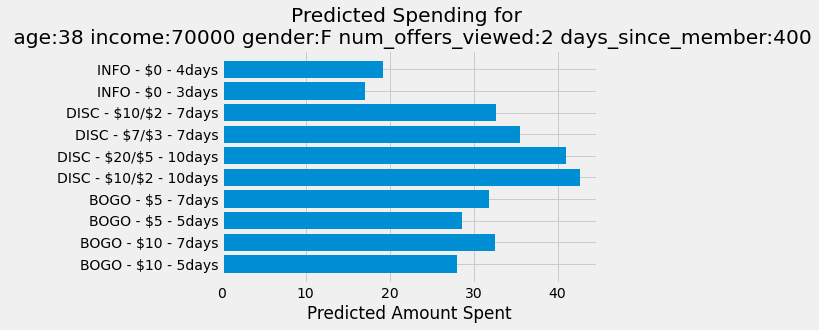

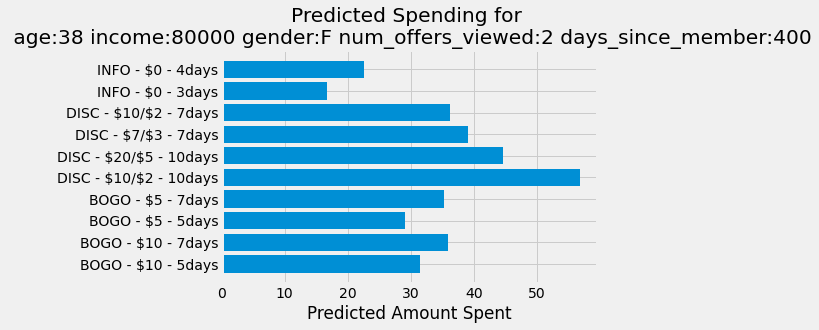

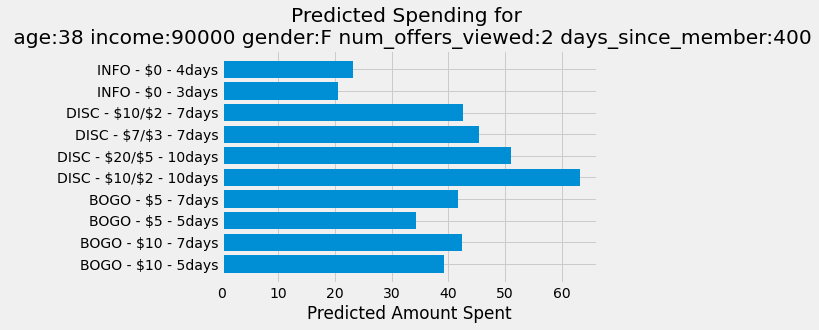

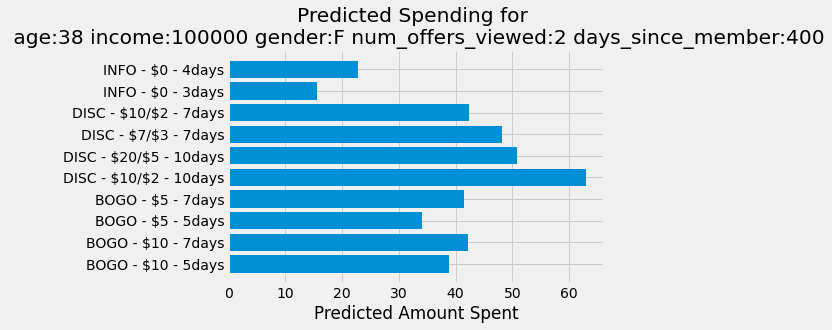

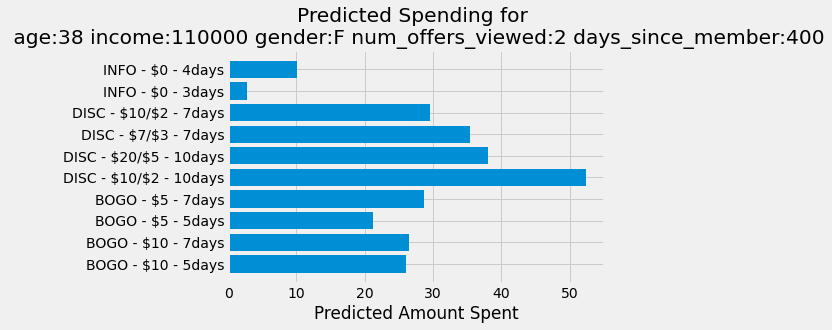

In [419]:
for income in range(70000,120000, 10000):
    which_coupon(age=38, income=income, gender='F', num_offers_viewed=2, days_since_member=400, model=final_xgbr)